In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Importing dataset:

In [9]:
import kagglehub

In [16]:
path = kagglehub.dataset_download("yasserh/titanic-dataset")
print("Path to dataset files:", path)

Path to dataset files: /Users/zakaria/.cache/kagglehub/datasets/yasserh/titanic-dataset/versions/1


In [18]:
# Load specific files
df = pd.read_csv(f"{path}/Titanic-Dataset.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [20]:
df.shape

(891, 12)

## Exploratory Data Analysis:

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [25]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

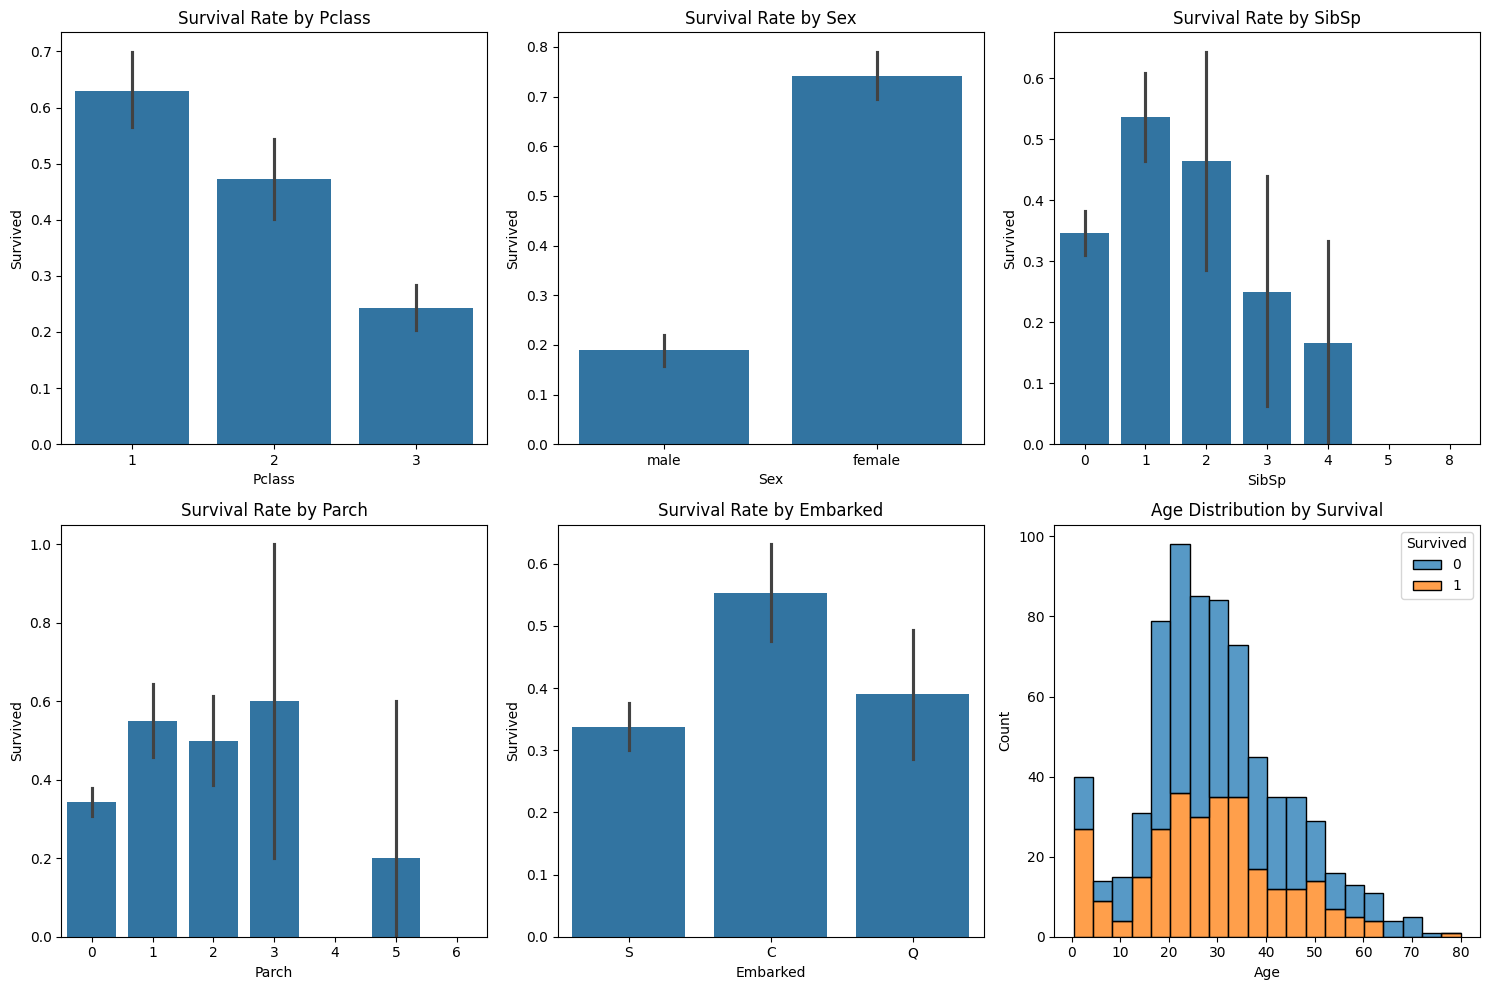

In [27]:
# Survival rate by different features
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Pclass vs Survival
sns.barplot(x='Pclass', y='Survived', data=df, ax=axes[0,0])
axes[0,0].set_title('Survival Rate by Pclass')

# Sex vs Survival
sns.barplot(x='Sex', y='Survived', data=df, ax=axes[0,1])
axes[0,1].set_title('Survival Rate by Sex')

# SibSp vs Survival
sns.barplot(x='SibSp', y='Survived', data=df, ax=axes[0,2])
axes[0,2].set_title('Survival Rate by SibSp')

# Parch vs Survival
sns.barplot(x='Parch', y='Survived', data=df, ax=axes[1,0])
axes[1,0].set_title('Survival Rate by Parch')

# Embarked vs Survival
sns.barplot(x='Embarked', y='Survived', data=df, ax=axes[1,1])
axes[1,1].set_title('Survival Rate by Embarked')

# Age distribution by Survival
sns.histplot(data=df, x='Age', hue='Survived', multiple='stack', ax=axes[1,2])
axes[1,2].set_title('Age Distribution by Survival')

plt.tight_layout()
plt.show()

In [224]:
import seaborn as sns

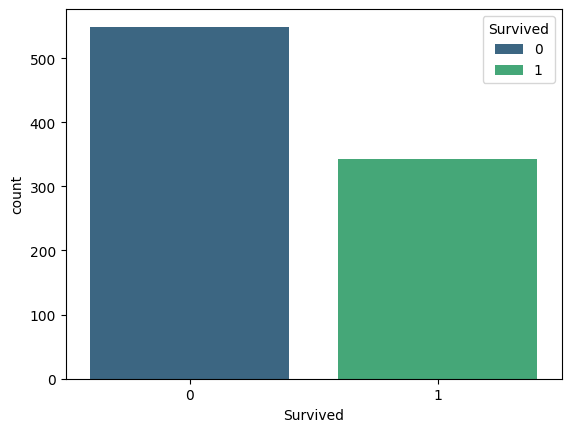

In [244]:
sns.countplot(data=df, x='Survived', hue='Survived', palette='viridis');

## Feature engineering:

In [141]:
def feature_engineering(df):
    """Create new features and transform existing ones"""
    df_processed = df.copy()
    
    # Extract title from Name
    df_processed['Title'] = df_processed['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
        # .str.extract() - String method to extract patterns
        # ' ([A-Za-z]+)\.' - Regular expression pattern
            # ' ' - Matches a space
            # [A-Za-z]+ - Matches one or more uppercase/lowercase letters
            # \. - Matches a literal dot (period)
            # The parentheses () capture the part we want to keep
        # expand=False - Returns a Series instead of DataFrame
    
    # Group rare titles
    title_mapping = {
        'Mr': 'Mr', 'Miss': 'Miss', 'Mrs': 'Mrs', 'Master': 'Master',
        'Dr': 'Rare', 'Rev': 'Rare', 'Col': 'Rare', 'Major': 'Rare',
        'Mlle': 'Miss', 'Ms': 'Miss', 'Lady': 'Rare', 'Sir': 'Rare',
        'Mme': 'Mrs', 'Don': 'Rare', 'Capt': 'Rare', 'Countess': 'Rare',
        'Jonkheer': 'Rare', 'Dona': 'Rare'
    }
    df_processed['Title'] = df_processed['Title'].map(title_mapping)
    
    # Family size features
    df_processed['FamilySize'] = df_processed['SibSp'] + df_processed['Parch'] + 1
    df_processed['IsAlone'] = (df_processed['FamilySize'] == 1).astype(int)
    
    # Cabin features
    df_processed['Deck'] = df_processed['Cabin'].str[0]
    df_processed['Deck'] = df_processed['Deck'].fillna('Unknown')
    df_processed['HasCabin'] = df_processed['Cabin'].notna().astype(int)

    # Age - impute with median based on Pclass and Title
    df_processed['Age'] = df_processed.groupby(['Pclass', 'Title'])['Age'].transform(lambda x: x.fillna(x.median()))
    # If still missing, fill with overall median
    df_processed['Age'] = df_processed['Age'].fillna(df_processed['Age'].median())

    # Age bins
    df_processed['AgeGroup'] = pd.cut(df_processed['Age'], 
                                     bins=[0, 12, 18, 35, 60, 100], 
                                     labels=['Child', 'Teen', 'Adult', 'Middle', 'Senior'])
    
    # Fare - fill with median based on Pclass
    df_processed['Fare'] = df_processed.groupby('Pclass')['Fare'].transform(lambda x: x.fillna(x.median()))
    
    # Fare bins
    df_processed['FareGroup'] = pd.qcut(df_processed['Fare'], 4, 
                                       labels=['Low', 'Medium', 'High', 'Very High'])

    # Embarked - fill with mode
    df_processed['Embarked'] = df_processed['Embarked'].fillna(df_processed['Embarked'].mode()[0])
    
    return df_processed

In [147]:
# Apply feature engineering
df_processed = feature_engineering(df)

print(">> New features created:\n")
df_processed[['Title', 'FamilySize', 'IsAlone', 'Deck', 'HasCabin', 'AgeGroup', 'FareGroup']].head()

>> New features created:



,Title,FamilySize,IsAlone,Deck,HasCabin,AgeGroup,FareGroup
0,Mr,2,0,Unknown,0,Adult,Low
1,Mrs,2,0,C,1,Middle,Very High
2,Miss,1,1,Unknown,0,Adult,Medium
3,Mrs,2,0,C,1,Adult,Very High
4,Mr,1,1,Unknown,0,Adult,Medium


In [149]:
df_processed.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,IsAlone,Deck,HasCabin,AgeGroup,FareGroup
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,2,0,Unknown,0,Adult,Low
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,2,0,C,1,Middle,Very High
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,1,1,Unknown,0,Adult,Medium
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,2,0,C,1,Adult,Very High
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,1,1,Unknown,0,Adult,Medium


## Clean the data:

In [179]:
df_clean = df_processed.copy()

In [181]:
df_clean = df_clean.drop(['PassengerId', 'Name', 'Age', 'Fare', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Deck'], axis=1)
df_clean.columns

Index(['Survived', 'Pclass', 'Sex', 'Embarked', 'Title', 'FamilySize',
       'IsAlone', 'HasCabin', 'AgeGroup', 'FareGroup'],
      dtype='object')

In [183]:
df_clean.head()

,Survived,Pclass,Sex,Embarked,Title,FamilySize,IsAlone,HasCabin,AgeGroup,FareGroup
0,0,3,male,S,Mr,2,0,0,Adult,Low
1,1,1,female,C,Mrs,2,0,1,Middle,Very High
2,1,3,female,S,Miss,1,1,0,Adult,Medium
3,1,1,female,S,Mrs,2,0,1,Adult,Very High
4,0,3,male,S,Mr,1,1,0,Adult,Medium


In [201]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Survived    891 non-null    int64   
 1   Pclass      891 non-null    int64   
 2   Sex         891 non-null    object  
 3   Embarked    891 non-null    object  
 4   Title       891 non-null    object  
 5   FamilySize  891 non-null    int64   
 6   IsAlone     891 non-null    int64   
 7   HasCabin    891 non-null    int64   
 8   AgeGroup    891 non-null    category
 9   FareGroup   891 non-null    category
dtypes: category(2), int64(5), object(3)
memory usage: 58.0+ KB


## Encode Categorical Variables:

In [192]:
# One-hot encoding for categorical variables
df_encoded = pd.get_dummies(df_clean, columns=['Sex', 'Embarked', 'Title', 'AgeGroup', 'FareGroup'], drop_first=True)

In [196]:
df_encoded.head()

,Survived,Pclass,FamilySize,IsAlone,HasCabin,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,AgeGroup_Teen,AgeGroup_Adult,AgeGroup_Middle,AgeGroup_Senior,FareGroup_Medium,FareGroup_High,FareGroup_Very High
0,0,3,2,0,0,True,False,True,False,True,False,False,False,True,False,False,False,False,False
1,1,1,2,0,1,False,False,False,False,False,True,False,False,False,True,False,False,False,True
2,1,3,1,1,0,False,False,True,True,False,False,False,False,True,False,False,True,False,False
3,1,1,2,0,1,False,False,True,False,False,True,False,False,True,False,False,False,False,True
4,0,3,1,1,0,True,False,True,False,True,False,False,False,True,False,False,True,False,False


## Prepare data for medeling:

In [216]:
from sklearn.model_selection import train_test_split

In [218]:
X = df_encoded.drop(['Survived'], axis=1)
y = df_encoded['Survived']

In [246]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# stratify=y - important for imbalanced datasets

In [250]:
from sklearn.preprocessing import StandardScaler

In [252]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Build the model:

## Logistic Regression model:

In [258]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [416]:
log_model = LogisticRegression(random_state=42, max_iter=1000)
log_model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [418]:
y_pred = log_model.predict(X_test_scaled)
y_pred_proba = log_model.predict_proba(X_test_scaled)

In [420]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.8379888268156425

In [422]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.86      0.87       110
           1       0.79      0.80      0.79        69

    accuracy                           0.84       179
   macro avg       0.83      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179



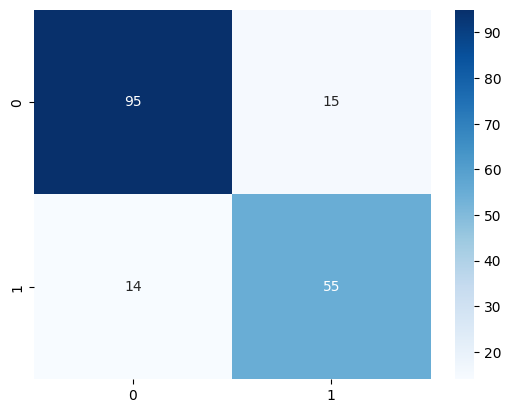

In [424]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, cmap='Blues')
plt.show()


 ======== Feature Importance (Coefficients) ========
                feature  coefficient  abs_coefficient
8              Title_Mr    -1.193482         1.193482
1            FamilySize    -0.785228         0.785228
13      AgeGroup_Middle    -0.689925         0.689925
4              Sex_male    -0.553789         0.553789
0                Pclass    -0.548978         0.548978
12       AgeGroup_Adult    -0.424263         0.424263
3              HasCabin     0.397083         0.397083
17  FareGroup_Very High     0.364413         0.364413
14      AgeGroup_Senior    -0.361817         0.361817
7            Title_Miss    -0.325692         0.325692
10           Title_Rare    -0.289735         0.289735
16       FareGroup_High     0.244976         0.244976
11        AgeGroup_Teen    -0.237855         0.237855
6            Embarked_S    -0.134009         0.134009
15     FareGroup_Medium     0.124197         0.124197
5            Embarked_Q     0.095136         0.095136
2               IsAlone    -

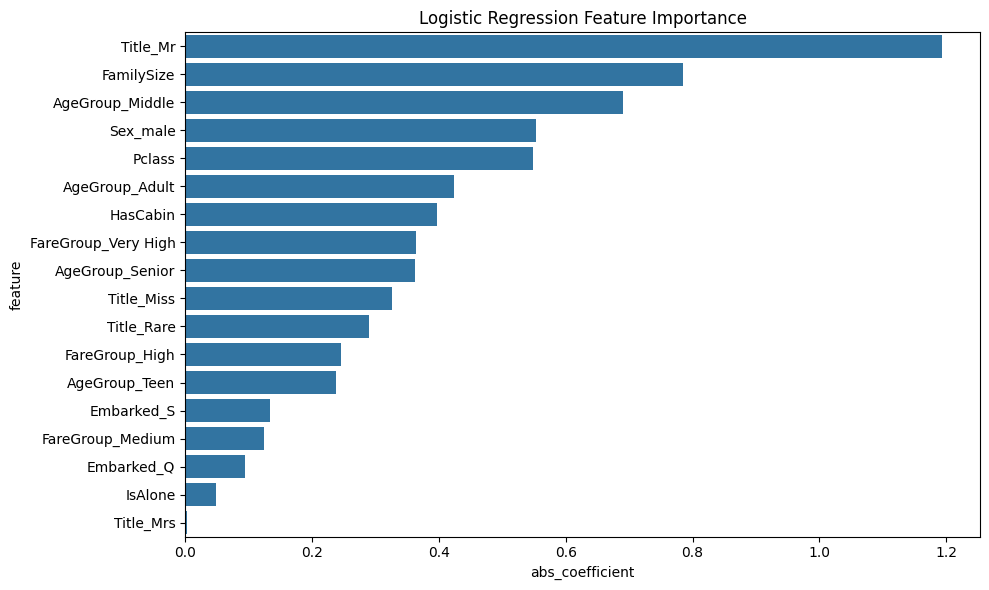

In [495]:
# >> Get feature coefficients:

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': log_model.coef_[0],
    'abs_coefficient': np.abs(log_model.coef_[0])
}).sort_values('abs_coefficient', ascending=False)

print("\n ======== Feature Importance (Coefficients) ========")
print(feature_importance)

# Interpretation: Positive coefficients increase survival probability
# Negative coefficients decrease survival probability

# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='abs_coefficient', y='feature')
plt.title('Logistic Regression Feature Importance')
plt.tight_layout()
plt.show()

In [428]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [442]:
# >> Hyperparameter Tuning:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(random_state=42, max_iter=100000))
])

# Define parameter grid

param_grid = {
    'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logreg__solver': ['liblinear', 'saga'],  # Both support L1 and L2
    'logreg__penalty': ['l1', 'l2']
}

In [444]:
# Grid search
#grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('logreg',
                                        LogisticRegression(max_iter=100000,
                                                           random_state=42))]),
             param_grid={'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'logreg__penalty': ['l1', 'l2'],
                         'logreg__solver': ['liblinear', 'saga']},
             scoring='accuracy')

In [448]:
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'logreg__C': 100, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'}
Best score: 0.8244656751699004


In [450]:
# Use best model
best_logreg = grid_search.best_estimator_
y_pred_best = best_logreg.predict(X_test)
print(f"Best model test accuracy: {accuracy_score(y_test, y_pred_best):.4f}")

Best model test accuracy: 0.8547


## Random Forest model:

In [457]:
from sklearn.ensemble import RandomForestClassifier

In [459]:
# Random Forest (no scaling needed)
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=5,
    n_jobs=-1
)

In [461]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, random_state=42)

In [465]:
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)

In [469]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.8044692737430168

In [471]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       110
           1       0.78      0.68      0.73        69

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



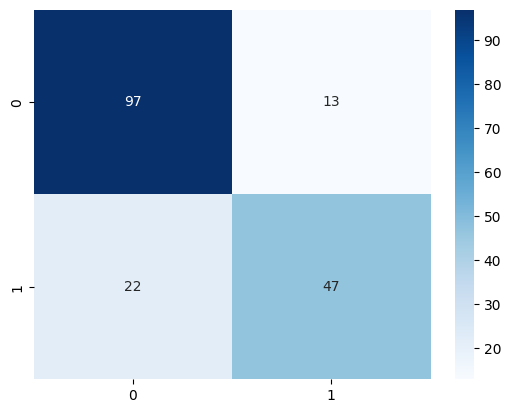

In [473]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, cmap='Blues')
plt.show()


=== Feature Importance ===
                feature  importance
8              Title_Mr    0.251557
4              Sex_male    0.229753
0                Pclass    0.117634
1            FamilySize    0.074920
3              HasCabin    0.067116
7            Title_Miss    0.065541
9             Title_Mrs    0.051269
17  FareGroup_Very High    0.026809
2               IsAlone    0.019690
6            Embarked_S    0.018535
15     FareGroup_Medium    0.013545
13      AgeGroup_Middle    0.013263
16       FareGroup_High    0.011949
10           Title_Rare    0.011856
12       AgeGroup_Adult    0.009115
5            Embarked_Q    0.008612
11        AgeGroup_Teen    0.004846
14      AgeGroup_Senior    0.003991


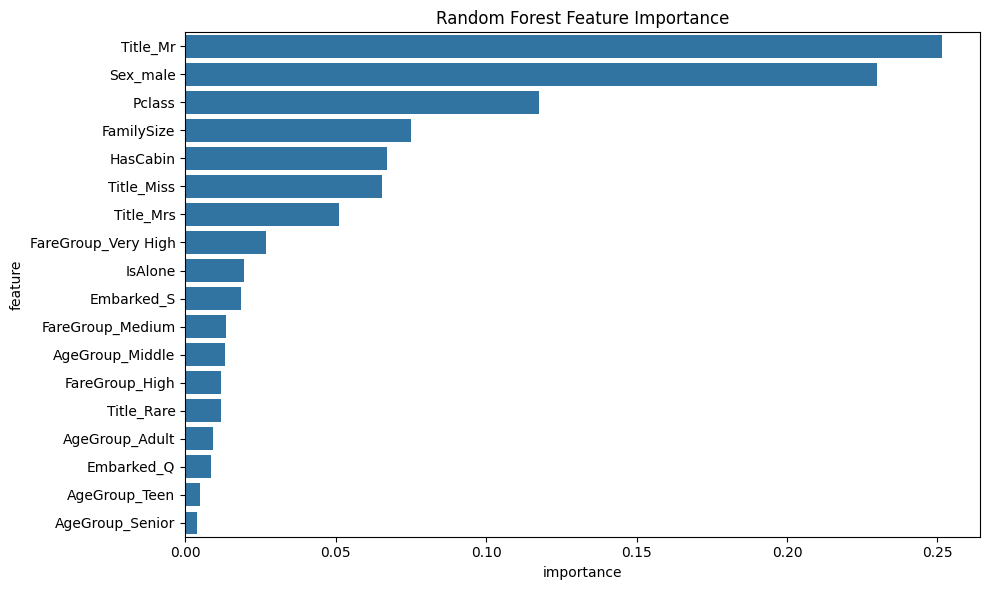

In [475]:
# >> Get feature importance

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\n=== Feature Importance ===")
print(feature_importance)

# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()

In [497]:
# >> Define parameter grid

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Grid search
rf_tuned = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf_tuned, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, None],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [499]:
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
Best cross-validation score: 0.8329262287008765


In [501]:
# Use best model
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test)
print(f"Best model test accuracy: {accuracy_score(y_test, y_pred_best):.4f}")

Best model test accuracy: 0.7877
